In [1]:
# Install catalax and PySR
# !pip install catalax pysr

In [2]:
import optax

import jax
import jax.numpy as jnp
import sympy as sp
import matplotlib.pyplot as plt

import catalax as ctx
import catalax.neural as cnn
import warnings

warnings.filterwarnings("ignore")

# Universal Ordinary Differential Equations 🧬⚡

Universal ODEs represent a powerful paradigm that seamlessly combines the interpretability of mechanistic ODE models with the flexibility of neural networks. This hybrid approach allows us to encode known physical or biological laws into the differential equation structure while using neural networks to capture unknown dynamics, model uncertainties, or missing physics that traditional models might overlook.

The core concept is to augment a traditional ODE system with a neural network component:

$$\frac{dy}{dt} = f(y, t, \theta) + NN(y, t, \phi)$$

where $f(y, t, \theta)$ represents the known mechanistic component with parameters $\theta$, and $NN(y, t, \phi)$ is a neural network with parameters $\phi$ that learns the unknown dynamics from data.

In this tutorial, we'll demonstrate this approach using enzyme kinetics as our case study, where we'll intentionally use an incomplete mechanistic model and let the neural network discover the missing competitive inhibition dynamics.

## Procedure

1. **Generate synthetic data** for the true underlying system → Competitive substrate inhibition kinetics
2. **Fit a simplified Michaelis-Menten model** to the data (missing the inhibition term)
3. **Implement a Universal ODE** that combines Michaelis-Menten + Neural Network correction
4. **Compare model performance** and analyze what the neural network learned
5. **Symbolic regression** to interpret the neural network's discovered dynamics


## 1. Generate $y_{true}$ data

We will generate data for a competitive substrate inhibition system. The system is governed by the following equation:

$$\frac{dS}{dt} = \frac{- v_{ max } * s_0 }{ K_m + s_0 * (1 + \frac{ s_0 }{ K_i }) }$$

where $v_{max}$ is the maximum velocity, $K_m$ is the Michaelis constant and $K_i$ is the inhibition constant.


In [3]:
model = ctx.Model(name="Universal ODE Example")

# Add species
model.add_state("s0")

# Set ODE equations
model.add_ode("s0", "-v_max * s0 / ( K_m + s0 * ( 1 + s0 / K_i ) )")

# Set parameter values
model.parameters["v_max"].value = 7.0
model.parameters["K_m"].value = 200.0
model.parameters["K_i"].value = 137.0

model

,name,symbol,type
0,s0,s0,None


,name,symbol,value,constant,initial_value,equation,lower_bound,upper_bound,hdi
0,K_i,K_i,137.0,False,None,None,None,None,None
1,K_m,K_m,200.0,False,None,None,None,None,None
2,v_max,v_max,7.0,False,None,None,None,None,None


""


""


""



Model(
    name='Universal ODE Example',
    odes=DottedDict({'s0': ODE(equation=-s0*v_max/(K_m + s0*(1 + s0/K_i)), parameters=DottedDict({'v_max': Parameter(name='v_max', symbol=v_max, value=7.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, hdi=None, prior=None), 'K_i': Parameter(name='K_i', symbol=K_i, value=137.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, hdi=None, prior=None), 'K_m': Parameter(name='K_m', symbol=K_m, value=200.0, constant=False, identifiability=None, initial_value=None, equation=None, lower_bound=None, upper_bound=None, hdi=None, prior=None)}), state=State(name='s0', symbol=s0, type=None), observable=True)}),
    states=,
    parameters=,
    reactions=,
    constants=,
    assignments=
)

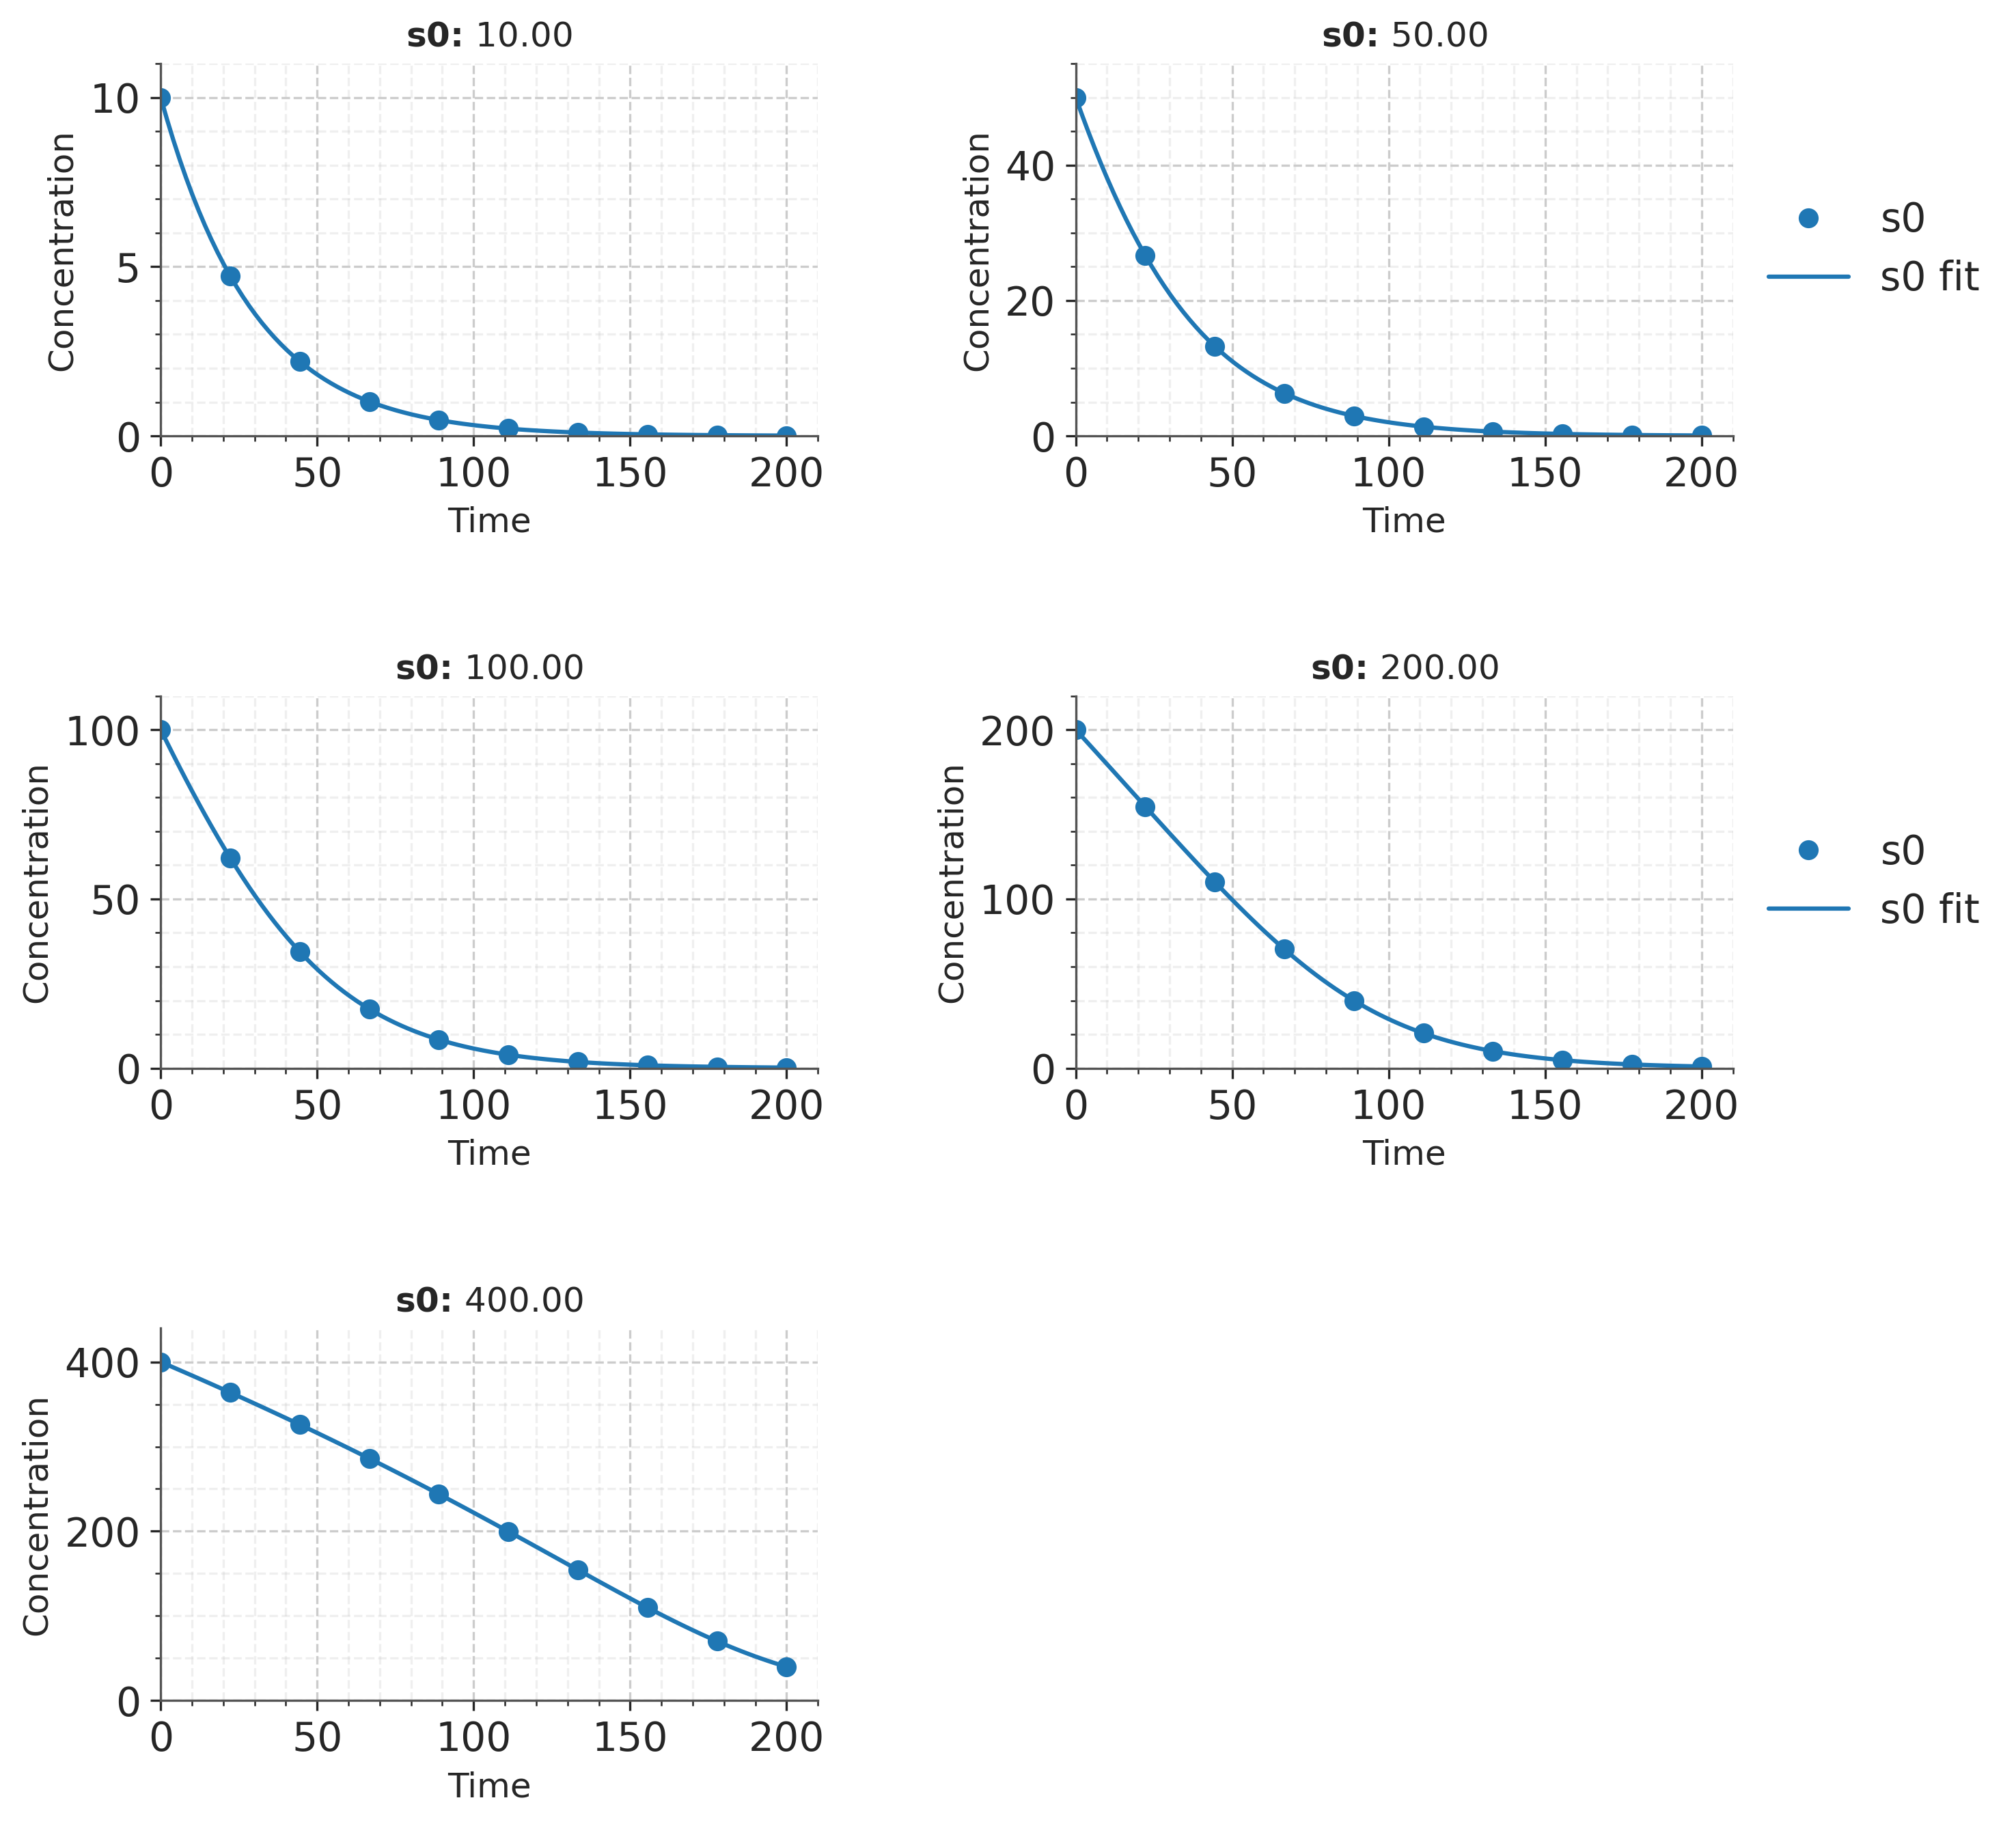

In [4]:
# Simulate for multiple initial conditions
dataset = ctx.Dataset.from_model(model)

# Add initial conditions
dataset.add_initial(s0=10.0)
dataset.add_initial(s0=50.0)
dataset.add_initial(s0=100.0)
dataset.add_initial(s0=200.0)
dataset.add_initial(s0=400.0)

# Simulate the system
config = ctx.SimulationConfig(t1=200, nsteps=10)
simulated = model.simulate(dataset, config)

simulated.plot(predictor=model, show=True)

## 2. Fit a regular Michaelis-Menten model to the data

Next we will fit a regular Michaelis-Menten model to the data. The model is given by:

$$\frac{dS}{dt} = \frac{- v_{ max } * s_0 }{ K_m + s_0 }$$

where $v_{max}$ is the maximum velocity and $K_m$ is the Michaelis constant.


In [5]:
# Create the model
model = ctx.Model(name="Michaelis Menten Example")
model.add_species(s0="Substrate")
model.add_ode("s0", "-v_max * s0 / ( K_m + s0 )")

model.parameters["v_max"].initial_value = 10.0
model.parameters["K_m"].initial_value = 200.0

# Use BFGS to fit the model
result, fitted_model = ctx.optimize(
    model=model,
    dataset=simulated,
    objective_fun=ctx.l1_loss,
    method="cobyla",
)

<lmfit.minimizer.MinimizerResult object at 0x365ebddd0>

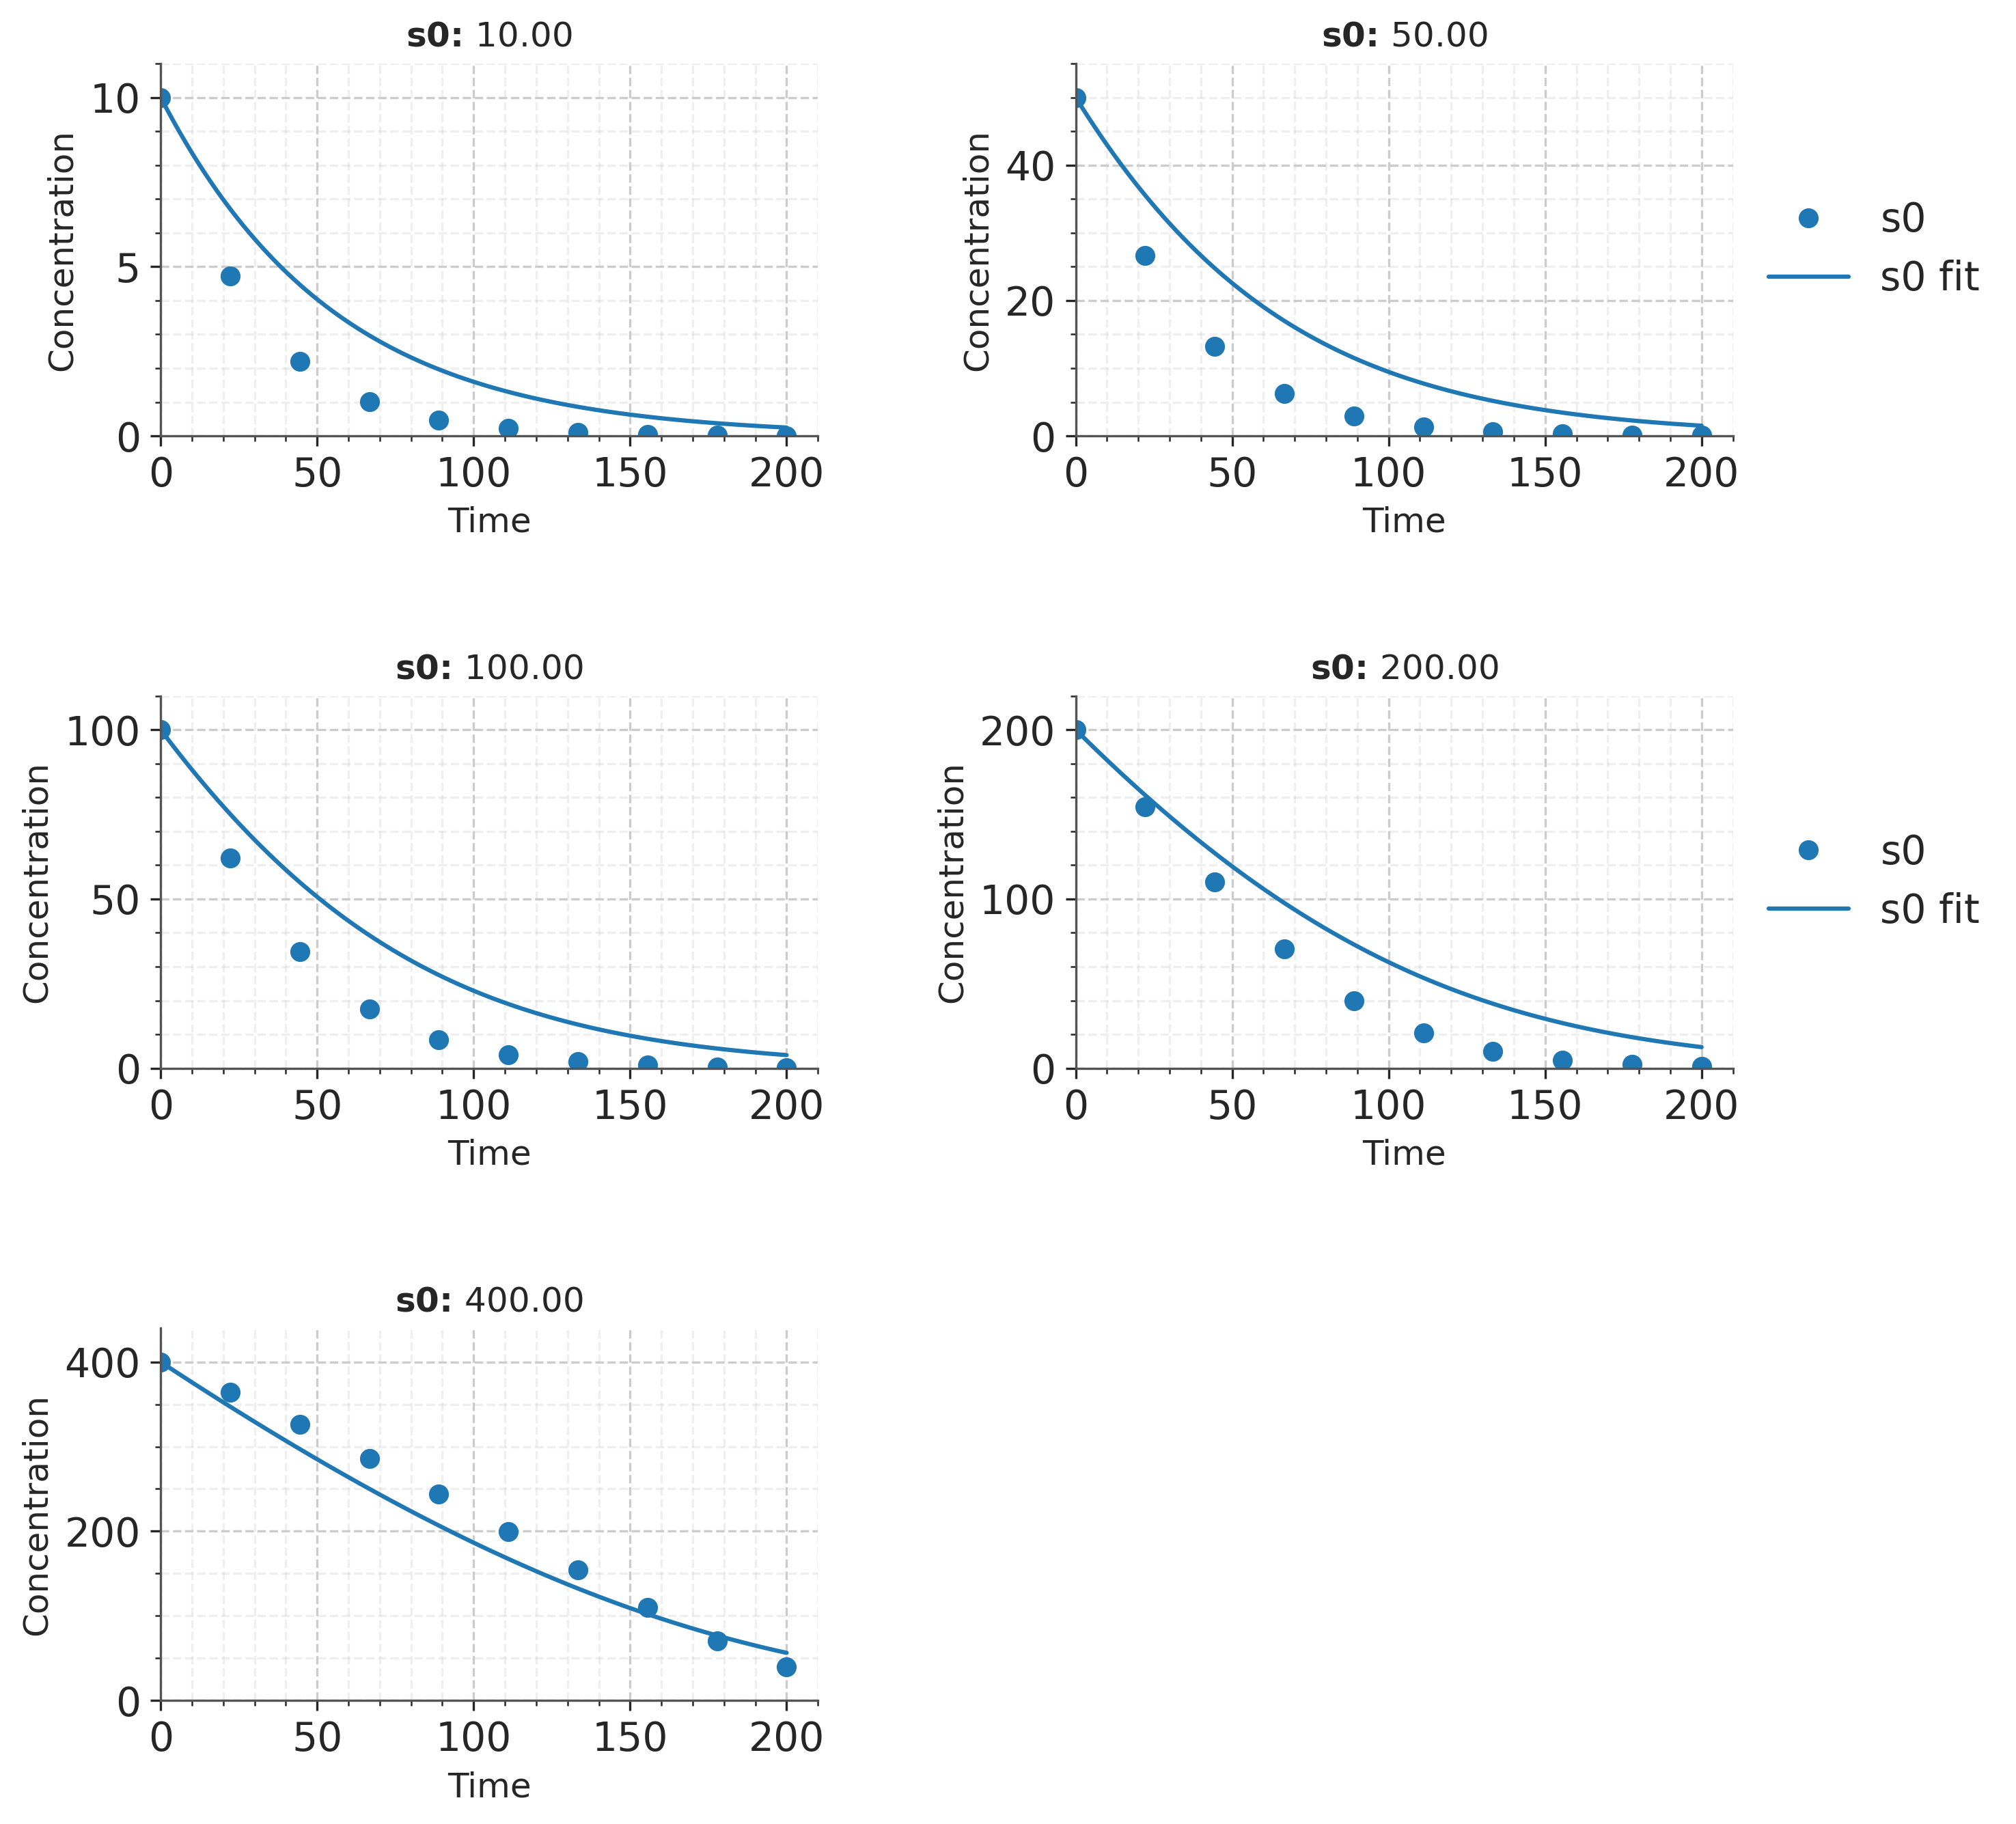

In [6]:
# Plot the fit
simulated.plot(predictor=fitted_model, show=True)

## 3. Fit a universal ODE to the data

The analysis reveals that the standard Michaelis-Menten model exhibits limitations in accurately capturing the system dynamics, particularly at low substrate concentrations. This discrepancy suggests that the classical kinetic formulation may be insufficient to describe the full complexity of the biochemical process under investigation.

To address these modeling limitations, we will implement a Universal ODE approach that incorporates a neural network component. This hybrid methodology combines the interpretable structure of the mechanistic Michaelis-Menten model with the flexibility of machine learning. The neural network will serve as a corrective term that learns to compensate for the systematic deviations observed in the deterministic model, thereby improving the overall predictive accuracy across the entire concentration range.


In [7]:
# Define the universal ODE
universal_ode = cnn.UniversalODE.from_model(
    model=fitted_model,
    width_size=3,
    depth=1,
    activation=jax.nn.celu,
    weight_scale=1e-8,
)

# Construct a strategy
penalties = cnn.Penalties.for_universal_ode()
strategy = cnn.Strategy(
    batch_size=2,
    loss=optax.log_cosh,
    penalties=penalties,
)

strategy.add_step(lr=1e-2, steps=1000, length=0.1)
strategy.add_step(lr=1e-3, steps=1000, batch_size=2)

# Train the universal ODE
trained = universal_ode.train(dataset=simulated, strategy=strategy)


🚀 Training UniversalODE...

🔸 Step #1
├── lr: 0.01
├── batch size: 2
├── length: 10.0%
├── train: mlp
│


╰── loss: 0.2056 mae: 0.4119: : 1010it [00:10, 99.40it/s]                         




🔸 Step #2
├── lr: 0.001
├── batch size: 2
├── length: 100.0%
├── train: mlp
│


╰── loss: 0.2512 mae: 0.4775: : 1010it [00:09, 107.25it/s]                        

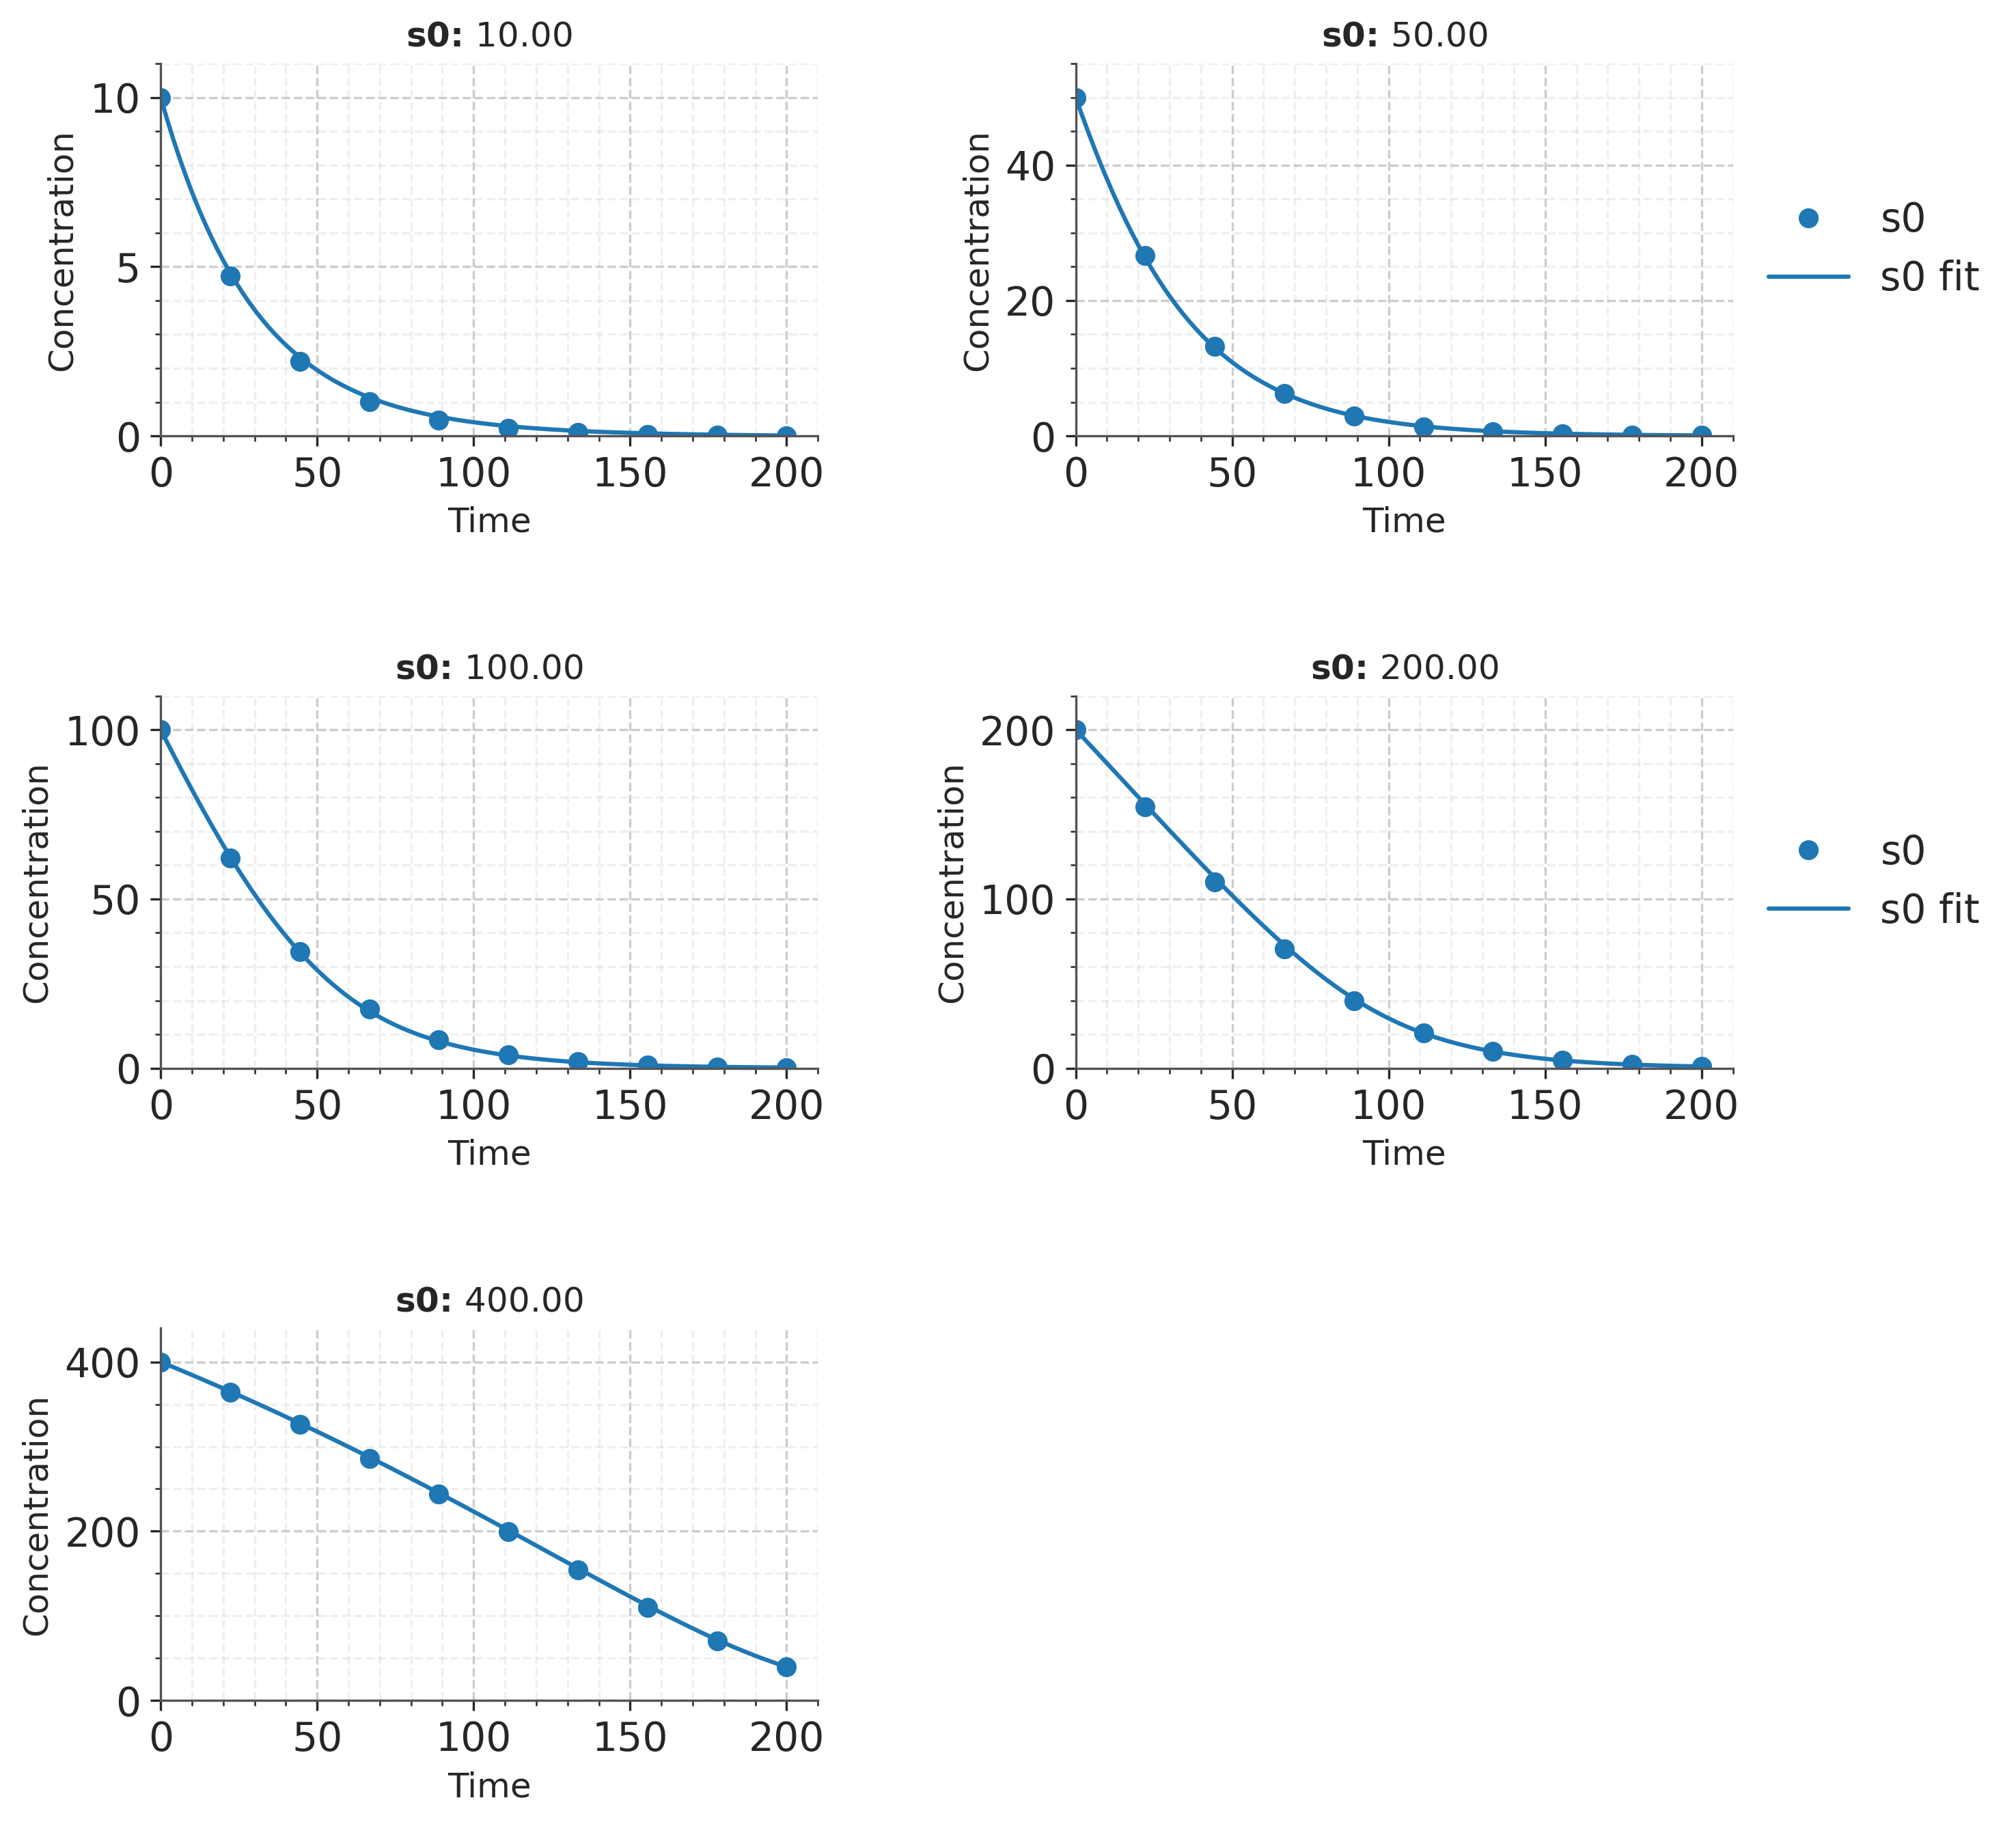

In [8]:
# Lets plot the predictions of the trained model.
simulated.plot(predictor=trained, show=True)

## Analyzing Neural Network Corrections

The following plot displays the corrective terms learned by the neural network component of our Universal ODE model.
These corrections represent the adjustments the neural network applies to compensate for discrepancies between 
the original mechanistic model and the observed data.

The x-axis represents substrate concentration (s0), while the y-axis shows the magnitude and direction of the 
neural network corrections. Positive values indicate regions where the original model underestimated the true 
dynamics, while negative values highlight areas where the mechanistic model overestimated the response.

This analysis provides insights into the systematic biases present in our mechanistic understanding and 
demonstrates how data-driven approaches can identify and correct for model inadequacies.

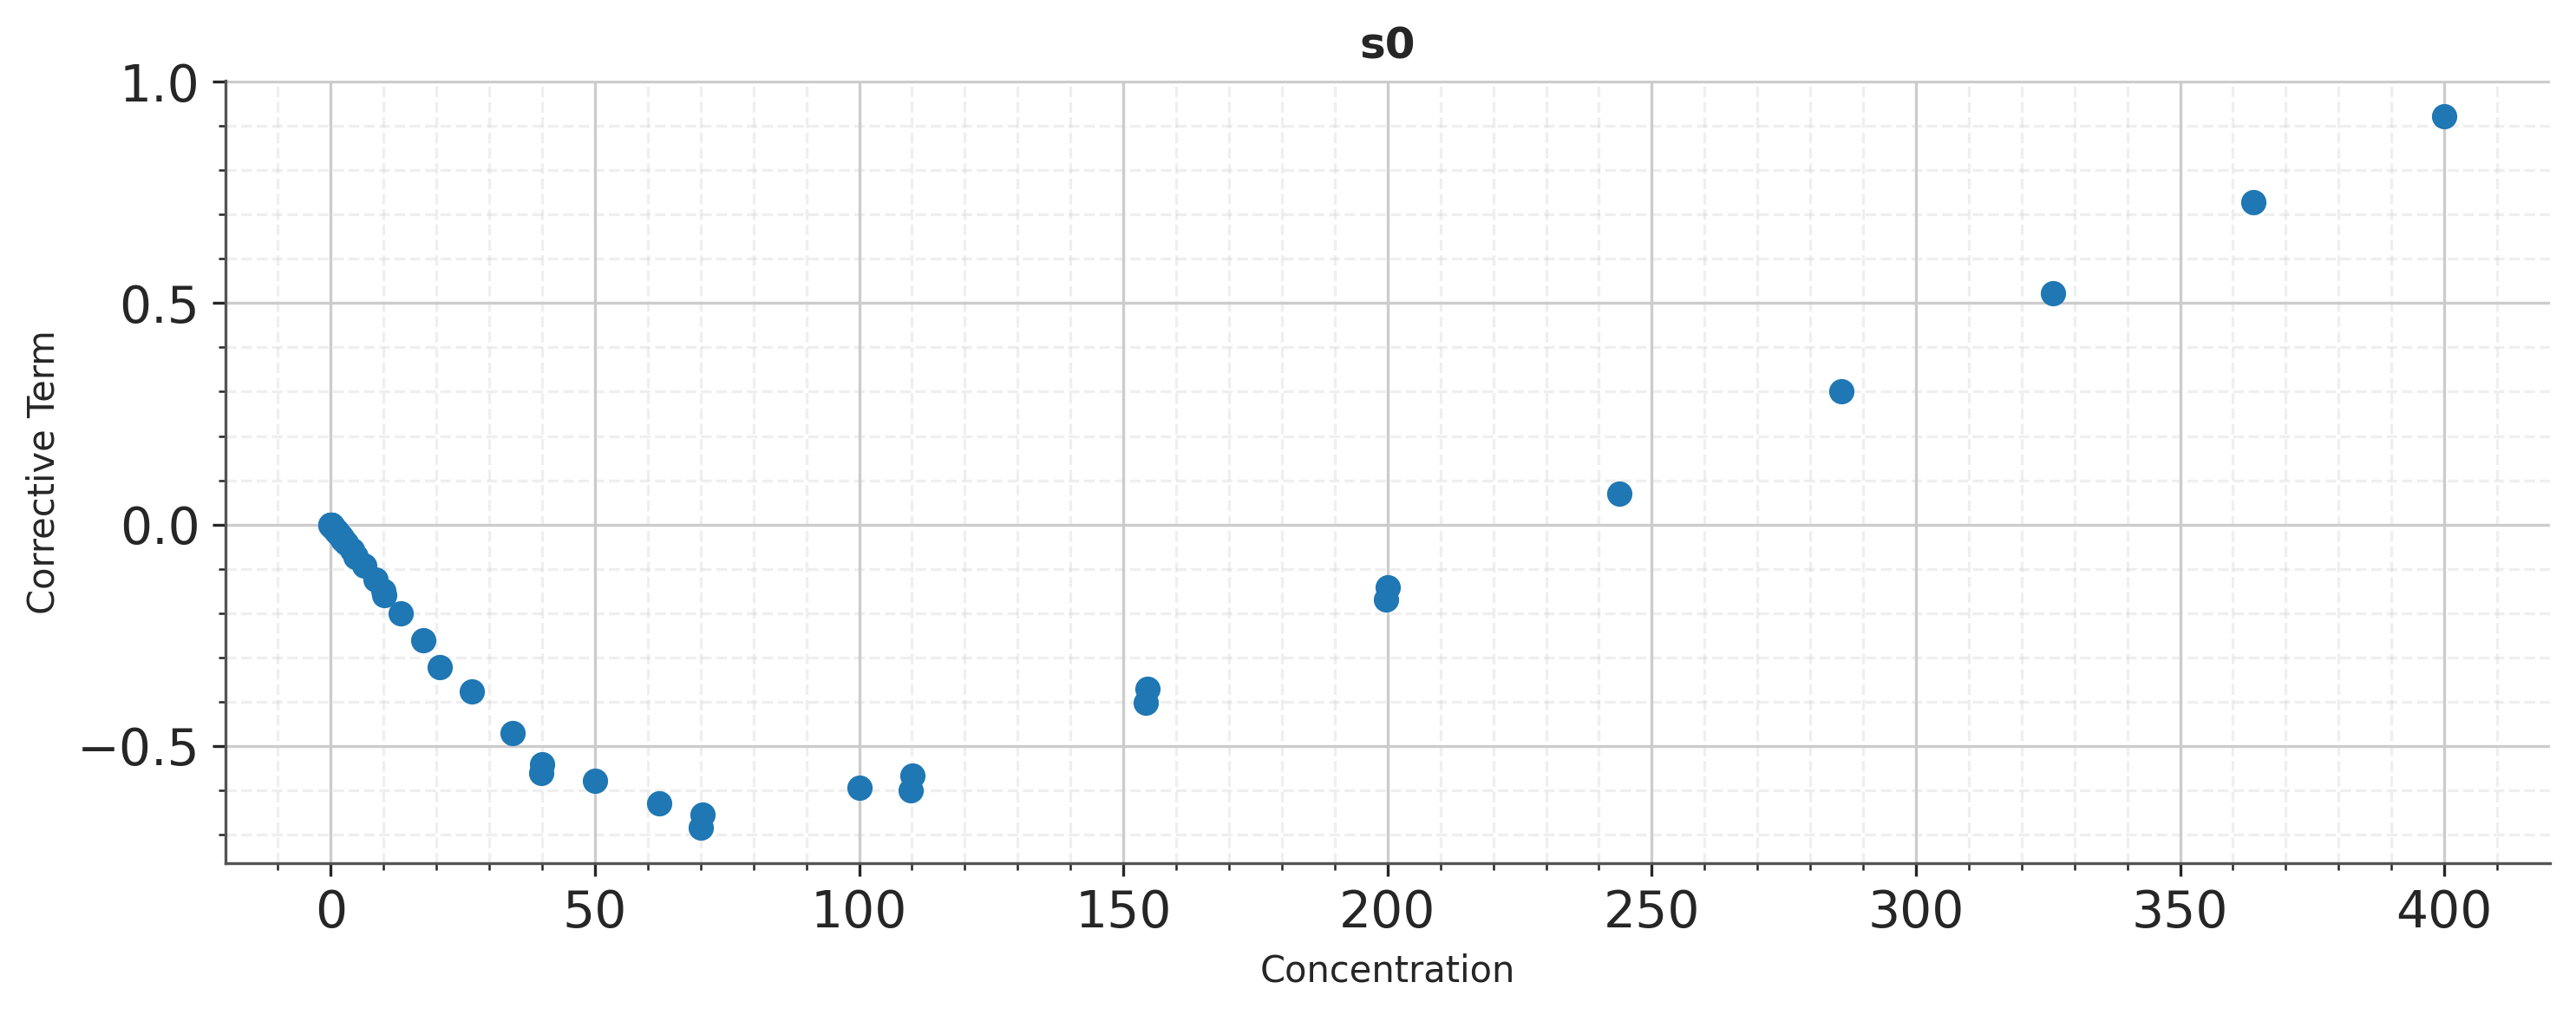

In [9]:
trained.plot_corrections_over_input(
    simulated,
    show=True,
    figsize=(10, 4),
)

## Symbolic Regression Analysis

Based on the neural network corrections plotted above, we observe patterns that suggest the corrective terms 
follow a saturation-like behavior, potentially resembling sigmoid or Michaelis-Menten kinetics. To quantify 
these patterns and derive interpretable mathematical expressions, we employ symbolic regression using PySR 
(Python Symbolic Regression).

Symbolic regression will systematically search through a space of mathematical expressions to identify 
the most parsimonious symbolic form that accurately captures the neural network's learned corrections. 
This approach allows us to:

1. Convert black-box neural network corrections into interpretable mathematical expressions
2. Identify potential missing terms or mechanisms in our original mechanistic model
3. Derive hybrid models that combine mechanistic knowledge with data-driven corrections
4. Validate our hypothesis about saturation kinetics in the corrective terms

The discovered symbolic expressions can then be integrated back into our mechanistic model, 
creating a more accurate and interpretable representation of the underlying biological processes.

In [10]:
# Configure PySR for corrective terms
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=400,
    deterministic=True,
    model_selection="score",
    unary_operators=["square"],
    binary_operators=["+", "-", "*", "/"],
    maxsize=20,
    maxdepth=5,
    populations=20,
    population_size=50,
    elementwise_loss="L1DistLoss()",
    complexity_of_operators={
        "+": 1,
        "-": 1,
        "*": 2,
        "/": 3,
        "square": 1,
        "log": 3,
        "neg": 1,
    },
    verbosity=0,
    random_state=10,
    parallelism="serial",
    variable_names=["s0"],
)

# Fit the model
data, _, _ = simulated.to_jax_arrays(trained.species_order)
corrections, _ = trained.corrective_term(simulated)
model.fit(
    data.ravel()[:, None],
    corrections.ravel()[:, None],
    variable_names=["s0"],
)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                       -0.054527197   
	1         0.013617                          square(s0) * 4.8307234e-6   
	2         0.095869                 square(square(s0 * -0.0025330246))   
	3         0.000004                     square(square(s0 / 394.72815))   
	4         0.079645    square(square(s0 * 0.0025826264)) + -0.07460947   
	5         0.555118            (s0 * 3.1487725e-5) * (s0 + -275.94156)   
	6         0.027614        (s0 * -74.854095) / (square(s0) + 4271.069)   
	7         0.268315     (s0 / (-28.128792 - s0)) - (s0 * -0.003933491)   
	8   >>>>  0.662361  s0 * ((s0 + -242.95937) / (square(s0) + 14006....   
	9         0.434531  s0 * (((s0 + s0) + -442.03787) / (square(s0) +...   
	10        0.145762  ((s0 * 5.887108) * (s0 + -232.29515)) / square...   
	11        0.029503  (((s0 * 5.8772736) + -1.2350917) * (s0 + -232....   
	12        0.000004  (((s0 * 5.877272) + -1.2350919) * (s0 + -232.2...   
	
	        loss  complexity  
	0   0.223937           1  
	1   0.212066           5  
	2   0.192680           6  
	3   0.192679           7  
	4   0.177928           8  
	5   0.102132           9  
	6   0.096644          11  
	7   0.073901          12  
	8   0.038106          13  
	9   0.015979          15  
	10  0.013812          16  
	11  0.013021          18  
	12  0.013020          20  
]

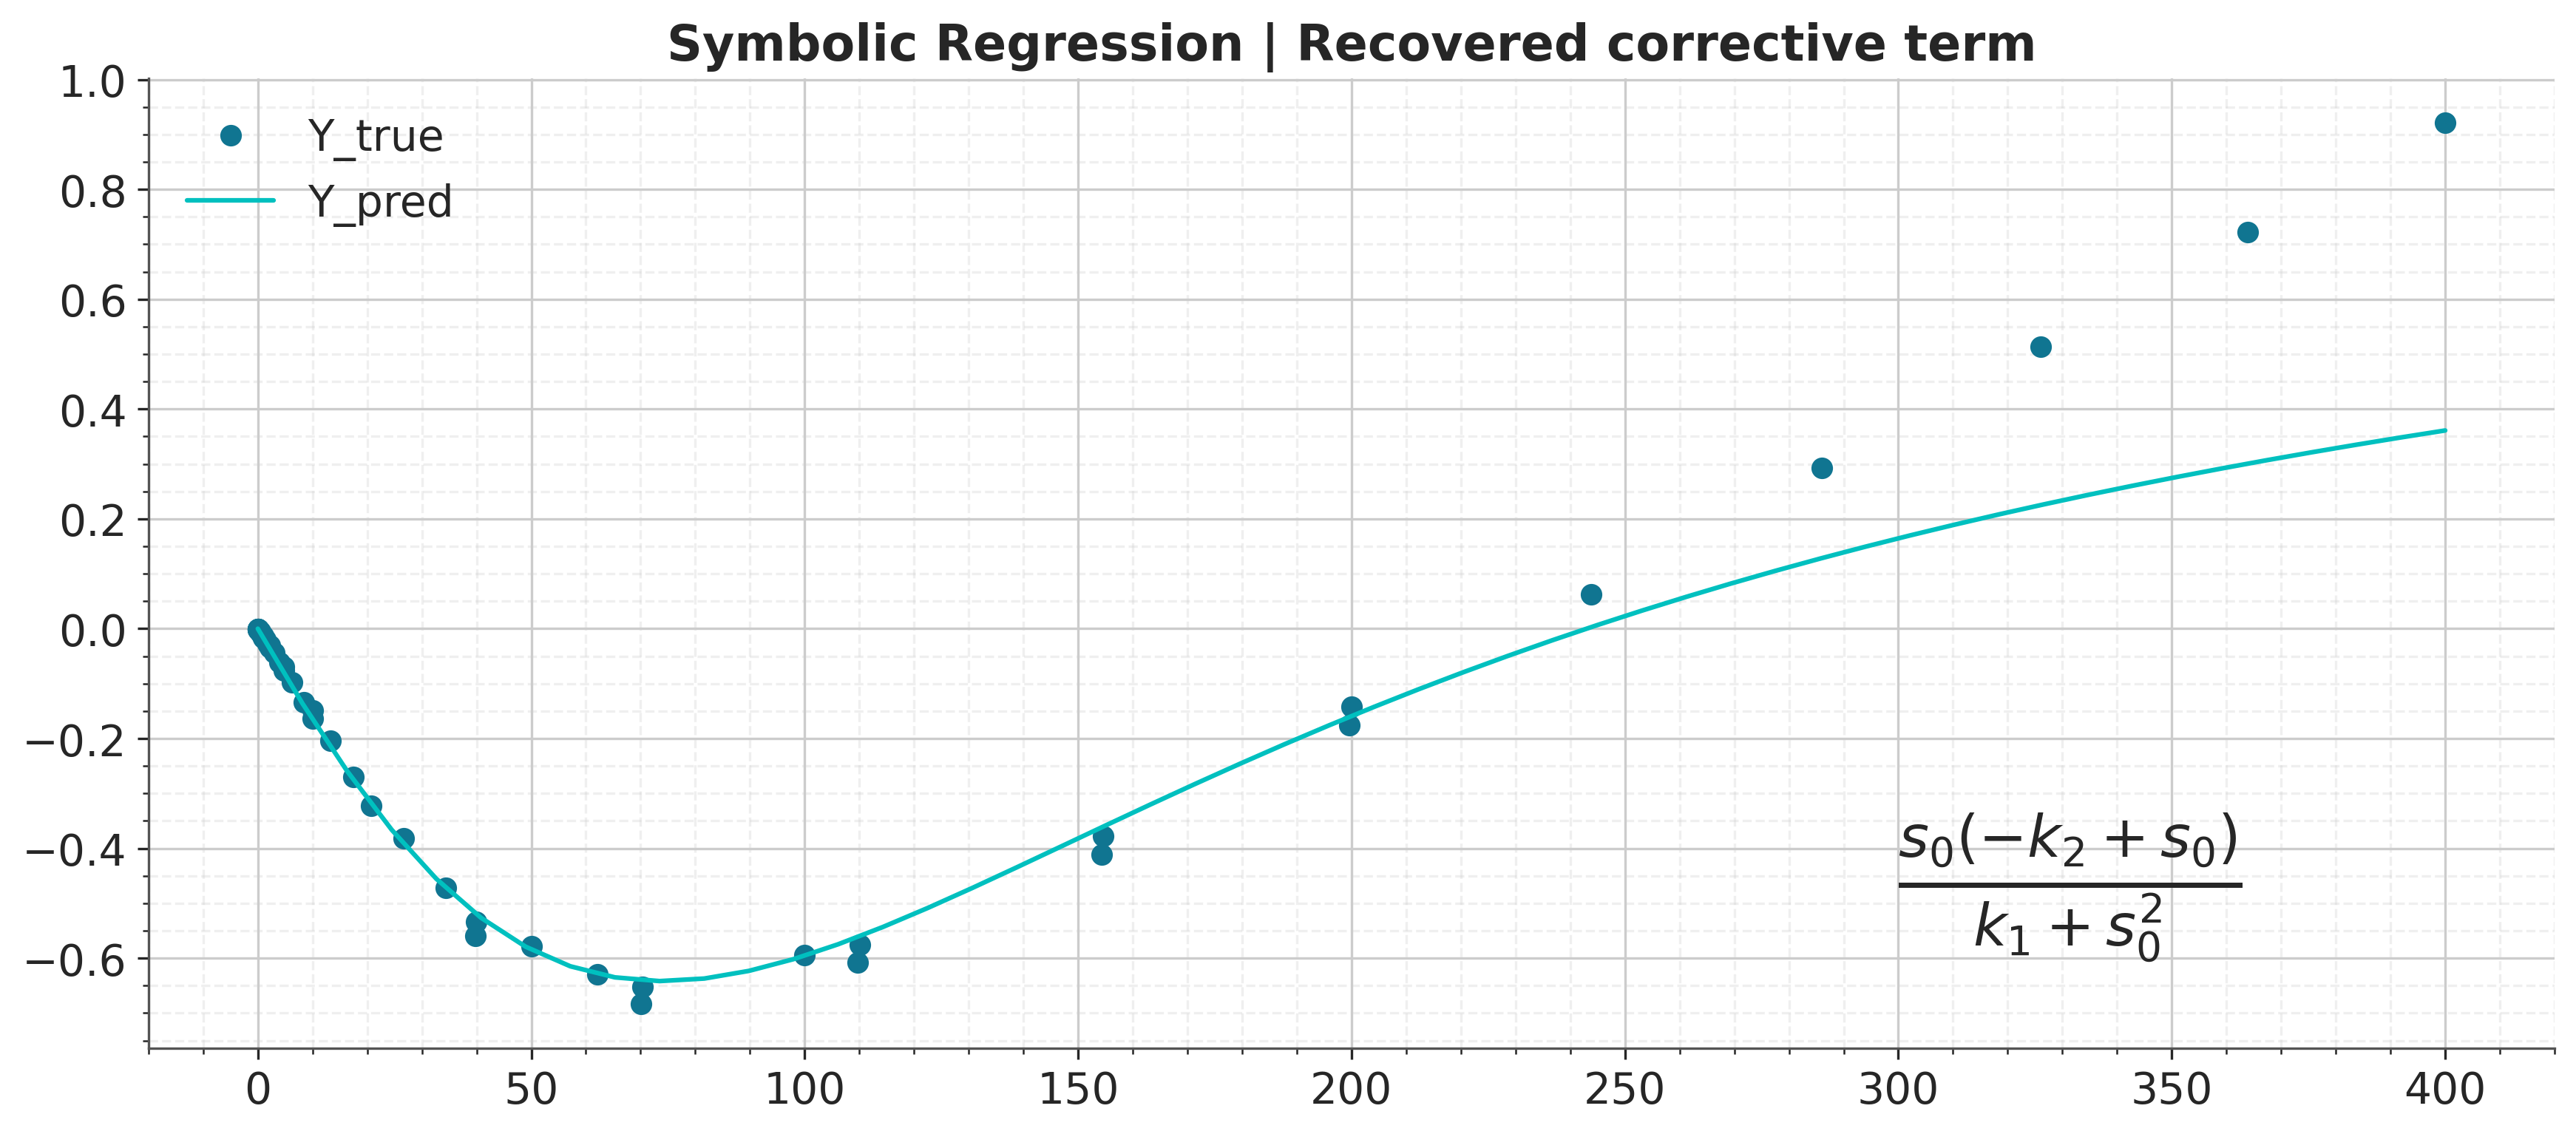

In [16]:
# Get the best equation from symbolic regression
eq = model.get_best()
sympy_eq = eq.sympy_format
param_pattern = "k{index}"

# Extract free numerical constants from the equation (excluding symbols and integers)
free_numbers = sympy_eq.atoms() - sympy_eq.atoms(sp.Symbol) - sympy_eq.atoms(sp.Integer)
number_map = {
    param_pattern.format(index=index + 1): abs(float(num))
    for index, num in enumerate(free_numbers)
}
inv_number_map = {v: k for k, v in number_map.items()}


# Replace numerical constants with symbolic parameters for cleaner representation
term = sympy_eq.subs(inv_number_map)

# Generate prediction data for visualization
X = jnp.linspace(0, 400)[:, None]
Y = eq.lambda_format(X)

# Create visualization of the symbolic regression results
plt.title("Symbolic Regression | Recovered corrective term")
plt.text(300, -0.5, f"${sp.latex(term)}$", fontsize=27)  # Display equation in LaTeX
plt.plot(
    data.ravel(), corrections.ravel(), "o", label="Y_true"
)  # Original correction data
plt.plot(X, Y, label="Y_pred")  # Predicted corrections from symbolic regression
plt.legend()

# Add grid for better readability
plt.grid(True, which="both")
plt.grid(True, which="minor", alpha=0.3, linestyle="--")
plt.minorticks_on()

<lmfit.minimizer.MinimizerResult object at 0x3f57be510>

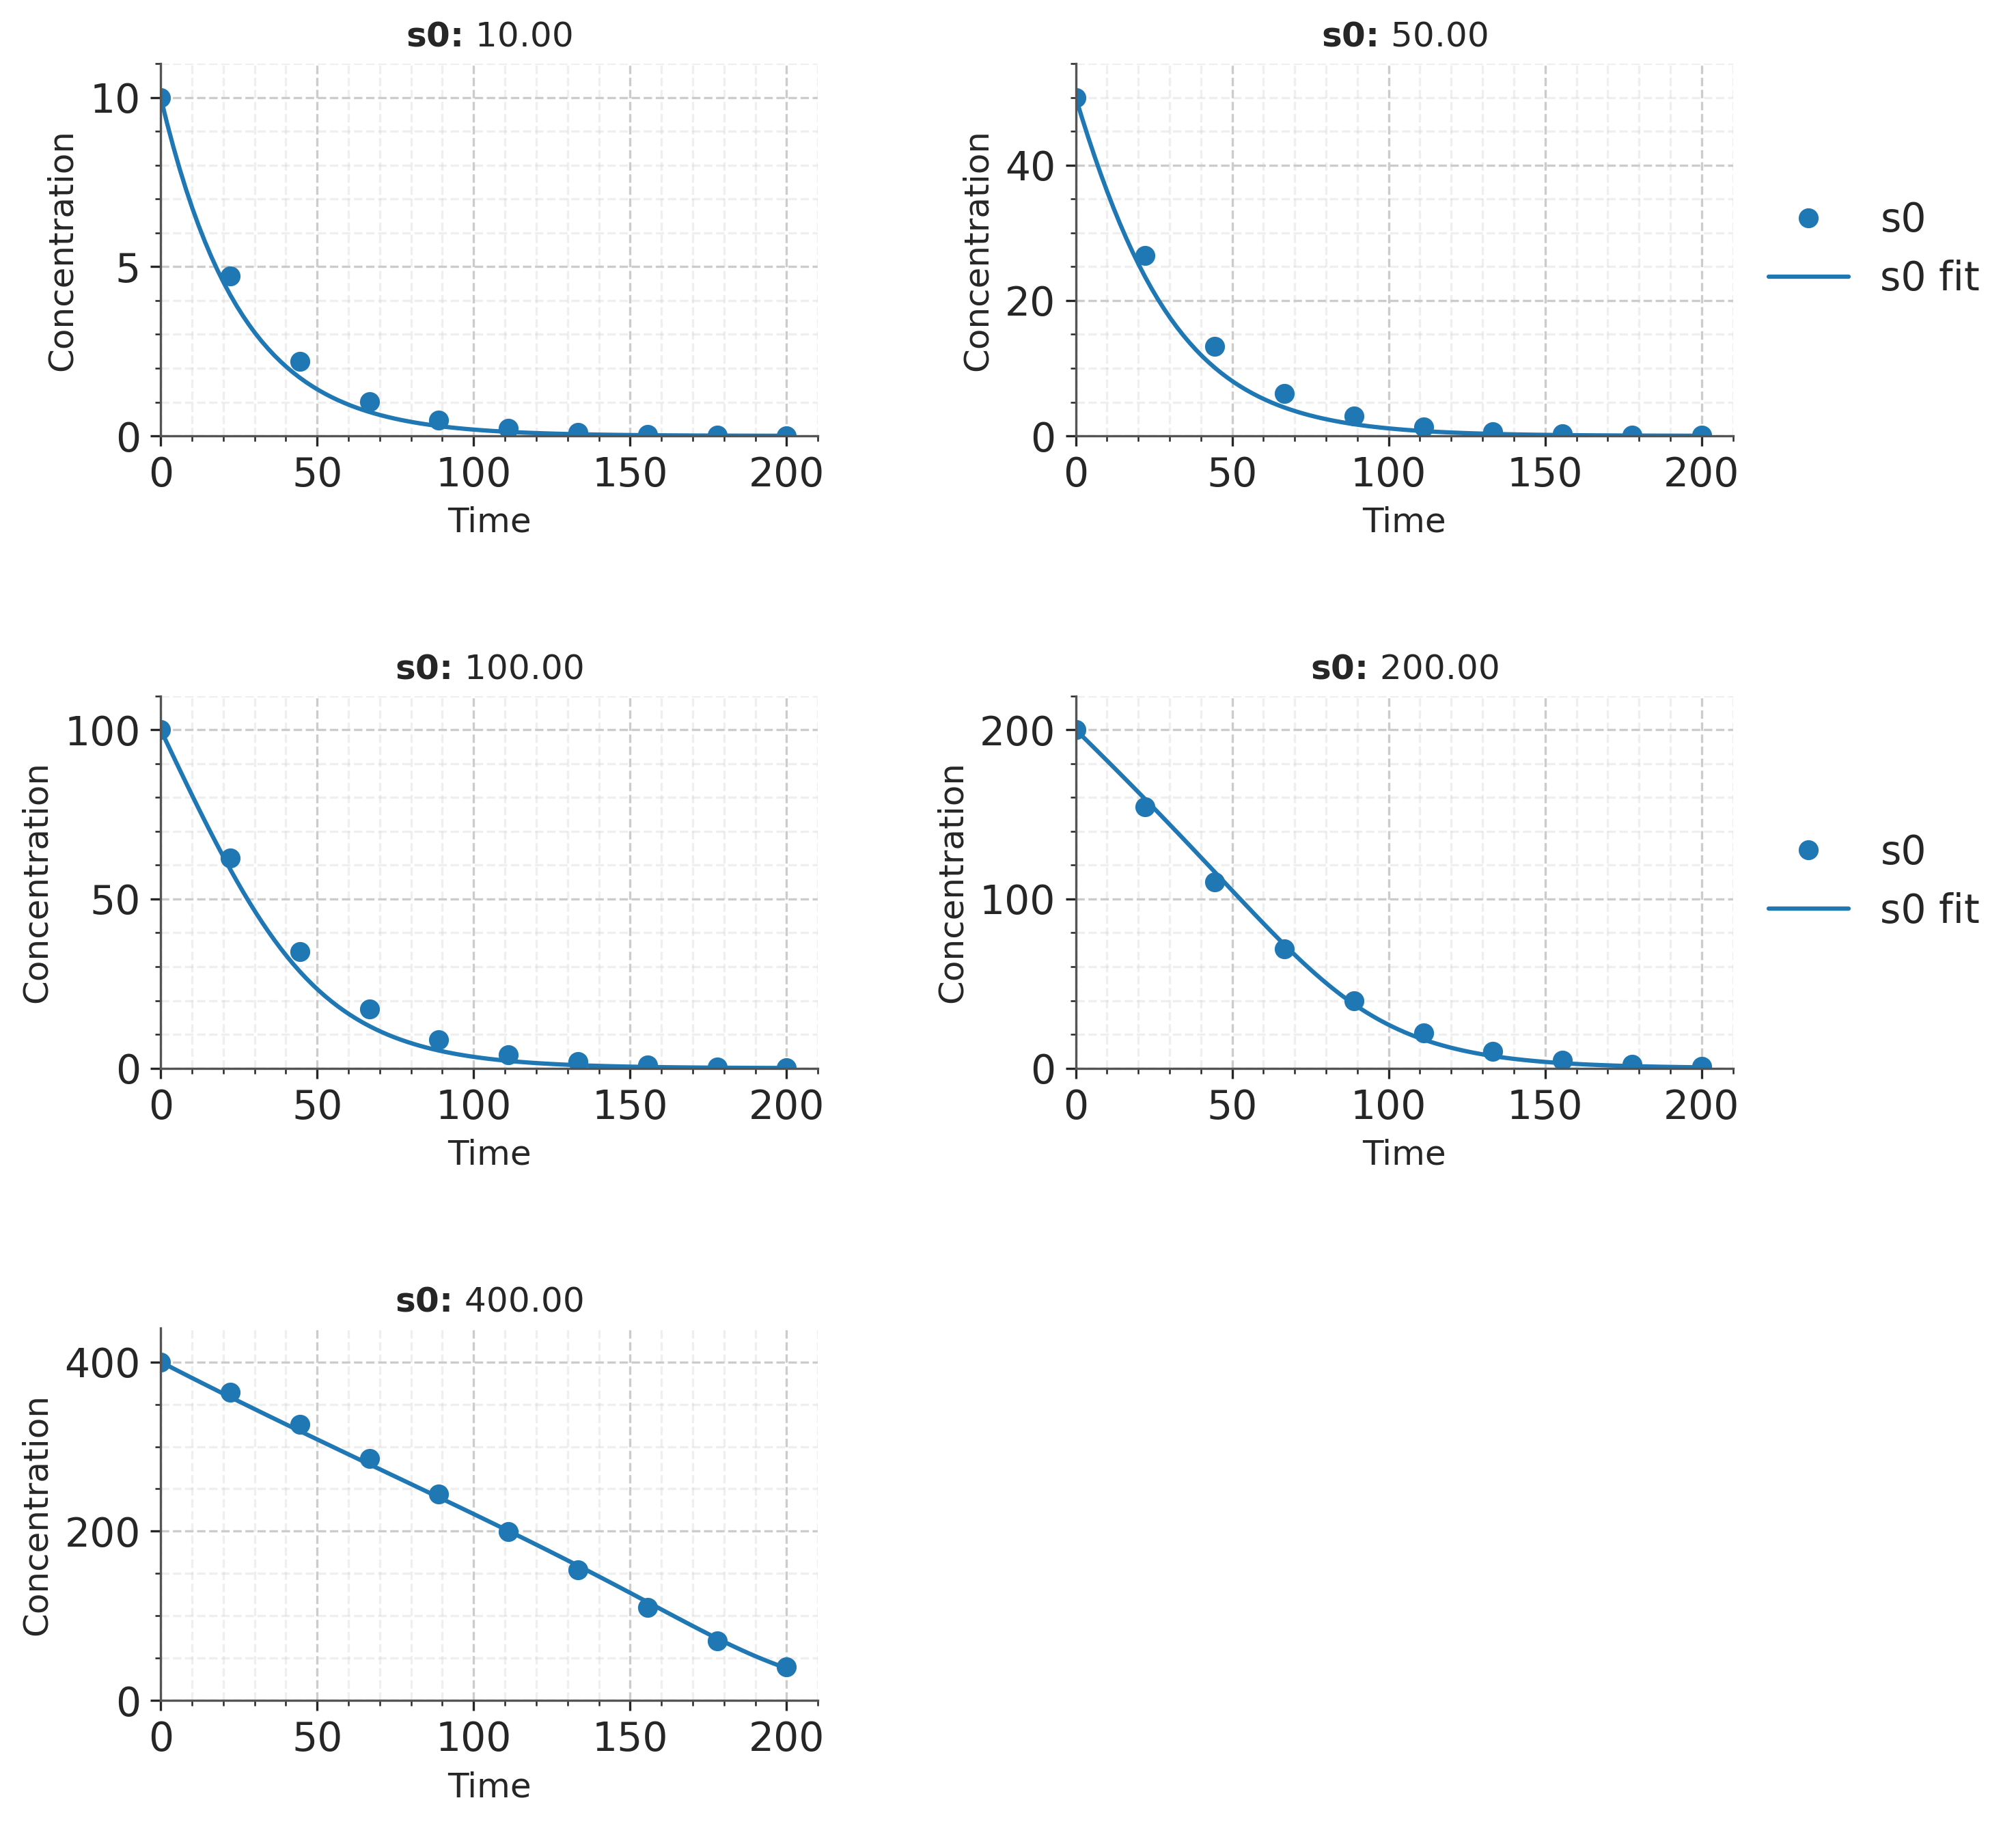

In [15]:
# Create a deep copy of the fitted model for symbolic regression enhancement
model_sr = fitted_model.model_copy(deep=True)
model_sr.reset()

# Set parameter values from the symbolic regression task
for i, parameter in enumerate(model_sr.parameters.values()):
    parameter.value = float(trained.parameters[i])
    parameter.initial_value = float(trained.parameters[i])

# Combine the original ODE with the discovered symbolic correction term
new_equation = fitted_model.odes["s0"].equation + term
model_sr.add_ode("s0", new_equation)

# Initialize parameters for the symbolic regression terms
for name, value in number_map.items():
    model_sr.parameters[name].initial_value = value

# Optimize the enhanced model with symbolic regression corrections
result, learnt = ctx.optimize(
    model=model_sr,
    dataset=simulated,
    objective_fun=optax.l2_loss,
    method="cobyla",
)

# Plot the results with the enhanced model
simulated.plot(predictor=learnt, show=True)
